# 8주차 과제 1번째

#### 통계학과 201618968 김종원

#### 환경 : colab

### import 

In [1]:
!pip install --upgrade fastai

In [2]:
import torch 
from fastai.vision.all import * 

In [3]:
import graphviz

In [4]:
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+ s + ';}')

### data 

`-` download data 

In [5]:
path = untar_data(URLs.MNIST_SAMPLE)

In [6]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv')]

`-` list 

In [7]:
threes=(path/'train'/'3').ls()
sevens=(path/'train'/'7').ls()

- 여기에서 tensor는 파이토치가 아니라 fastai에서 구현한 함수임 

`-` 여러개의 리스트를 모두 텐서로 바꿔보자. 

In [8]:
seven_tensor = torch.stack([tensor(Image.open(i)) for i in sevens]).float()/255
three_tensor = torch.stack([tensor(Image.open(i)) for i in threes]).float()/255

`-` $X$와 $y$를 만들자. 

In [9]:
seven_tensor.shape, three_tensor.shape

(torch.Size([6265, 28, 28]), torch.Size([6131, 28, 28]))

In [10]:
y=torch.tensor([0.0]*6265+ [1.0]*6131).reshape(12396,1)

In [11]:
X=torch.vstack([seven_tensor,three_tensor]).reshape(12396,-1)

In [12]:
X.shape, y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [13]:
X=X.reshape(12396,1,28,28)

In [14]:
X.shape

torch.Size([12396, 1, 28, 28])

### 네트워크 설계

#### step1: dls 만들기

In [15]:
ds=torch.utils.data.TensorDataset(X, y)
ds1,ds2=torch.utils.data.random_split(ds, [10000,2396])
dl1=torch.utils.data.DataLoader(ds1, batch_size=1000)
dl2=torch.utils.data.DataLoader(ds2, batch_size=2396)
dls=DataLoaders(dl1, dl2)

#### step2: 아키텍처, 손실함수, 옵티마이저

In [16]:
class Flatten(torch.nn.Module):
  def forward(self, x):
    return x.reshape(x.shape[0], -1)

In [17]:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, 5), 
    torch.nn.MaxPool2d(2), 
    torch.nn.ReLU(), 
    torch.nn.Dropout2d())

In [18]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(1), 
    Flatten(), 
    torch.nn.Linear(16, 1, bias=False))

In [19]:
net = torch.nn.Sequential(net1, net2)

In [20]:
loss_fn = torch.nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(net.parameters())

#### step3: lrnr 생성 후 적합

In [21]:
lrnr = Learner(dls, net, opt_func=Adam, loss_func=loss_fn, lr=0.1)

In [22]:
lrnr.fit(10)

epoch,train_loss,valid_loss,time
0,0.674935,0.603885,00:00
1,0.634070,0.506970,00:00
2,0.605381,0.472672,00:00
3,0.583827,0.448677,00:00
4,0.564289,0.403919,00:00
5,0.547216,0.385691,00:00
6,0.530072,0.355181,00:00
7,0.514838,0.343336,00:00
8,0.501207,0.319178,00:00
9,0.486636,0.305142,00:00


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [23]:
a2 = torch.nn.Sigmoid()

### CAM

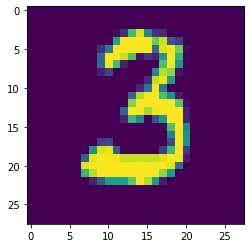

In [34]:
x = X[10000]
x = x.reshape(1, 1, 28, 28)
plt.imshow(x.squeeze())

In [35]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten()
  (2): Linear(in_features=16, out_features=1, bias=False)
)

In [36]:
ap = torch.nn.AdaptiveAvgPool2d(output_size=1)

In [37]:
camimg = torch.einsum('i,ijk -> jk',net2[2].weight.squeeze(), net1(x).squeeze())

In [38]:
net2(net1(x)), ap(camimg)

(tensor([[0.5411]], grad_fn=<MmBackward>),
 tensor([[0.5411]], grad_fn=<MeanBackward1>))

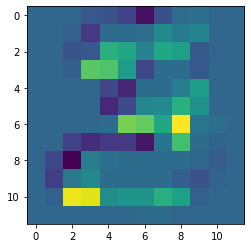

In [39]:
plt.imshow(camimg.data)

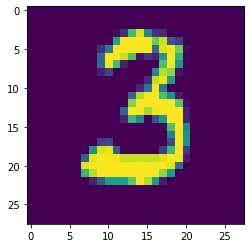

In [40]:
plt.imshow(x.squeeze()) 

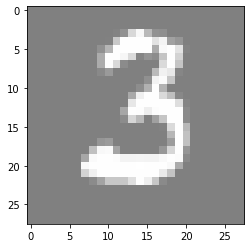

In [41]:
plt.imshow(x.squeeze(),cmap='gray',alpha=0.5)

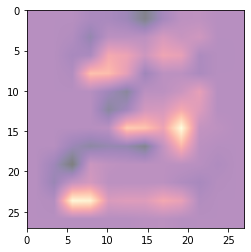

In [42]:
plt.imshow(camimg.data,alpha=0.5, extent=(0,27,27,0),interpolation='bilinear',cmap='magma')

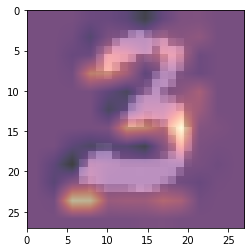

In [43]:
plt.imshow(x.squeeze(),cmap='gray',alpha=0.5)
plt.imshow(camimg.data,alpha=0.5, extent=(0,27,27,0),interpolation='bilinear',cmap='magma')

- 노란 부분이 3이라고 판단하는 근거가 되는 부분입니다.